In [1]:
import numpy as np

fs = 44100
ir = np.load('files/FABIAN-hrtf.npy')

In [2]:
ir.shape

(256, 2, 11950)

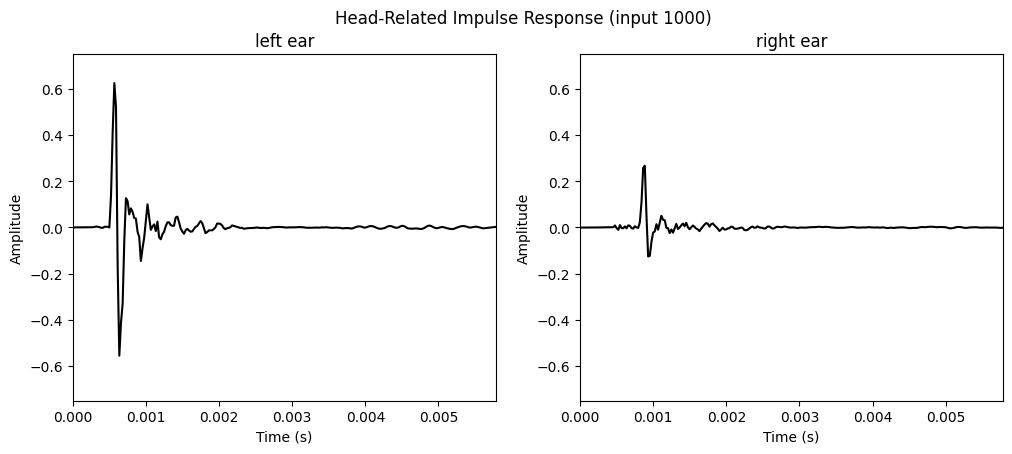

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 4.5)

input_idx = 1000

t = np.arange(ir.shape[0])/fs

fig, axes = plt.subplots(1, 2)
fig.suptitle(f'Head-Related Impulse Response (input {input_idx})')
for i, ax in enumerate(axes): 
    ax.plot(t, ir[:, i, input_idx], color='k')
    ax.set(xlabel=r'Time (s)', ylabel='Amplitude', title=f'{"left" if i == 0 else "right"} ear', xlim=(t[0], t[-1]), ylim=(-0.75, 0.75))

In [4]:
from pymor.operators.numpy import NumpyHankelOperator

H = NumpyHankelOperator(ir)

In [5]:
print(H)

NumpyHankelOperator: R^1541550 --> R^258  (parameters: {}, class: NumpyHankelOperator)


In [6]:
from pymor.reductors.era import ERAReductor

era = ERAReductor(ir, sampling_time=1/fs)

In [7]:
from pymor.tools.formatsrc import print_source

print_source(ERAReductor.reduce)

def reduce(self, r=None, tol=None, num_left=None, num_right=None):
        """Construct a minimal realization.

        Parameters
        ----------
        r
            Order of the reduced model if `tol` is `None`, maximum order if `tol` is specified.
        tol
            Tolerance for the error bound.
        num_left
            Number of left (output) directions for tangential projection.
        num_right
            Number of right (input) directions for tangential projection.

        Returns
        -------
        rom
            Reduced-order |LTIModel|.
        """
        assert r is not None or tol is not None
        n, p, m = self.data.shape
        s = n if self.force_stability else (n + 1) // 2
        assert num_left is None or isinstance(num_left, int) and 0 < num_left < p
        assert num_right is None or isinstance(num_right, int) and 0 < num_right < m
        assert r is None or 0 < r <= min((num_left or p), (num_right or m)) * s

        sv, U, V = self._sv_U_V(num_left, num_right)

        if tol is not None:
            error_bounds = self.error_bounds(num_left=num_left, num_right=num_right)
            r_tol = np.argmax(error_bounds <= tol) + 1
            r = r_tol if r is None else min(r, r_tol)

        sv, U, V = sv[:r], U[:r], V[:r]

        num_left = m * s if num_left is None and m * s < p else num_left
        num_right = p * s if num_right is None and p * s < m else num_right

        self.logger.info(f'Constructing reduced realization of order {r} ...')
        sqS = np.diag(np.sqrt(sv))
        Zo = U.T @ sqS
        A = NumpyMatrixOperator(spla.lstsq(Zo[: -(num_left or p)], Zo[(num_left or p):])[0])
        B = NumpyMatrixOperator(sqS @ V[:, :(num_right or m)])
        C = NumpyMatrixOperator(Zo[:(num_left or p)])

        if num_left:
            self.logger.info('Backprojecting tangential output directions ...')
            W1 = self.output_projector(num_left)
            C = project(C, source_basis=None, range_basis=C.range.from_numpy(W1))
        if num_right:
            self.logger.info('Backprojecting tangential input directions ...')
            W2 = self.input_projector(num_right)
            B = project(B, source_basis=B.source.from_numpy(W2), range_basis=None)

        return LTIModel(A, B, C, D=self.feedthrough, sampling_time=self.sampling_time,
                        presets={'o_dense': np.diag(sv), 'c_dense': np.diag(sv)})

In [15]:
from pymor.tools.timing import Timer

roms = dict()
with Timer('Initial computation (r=80)'):
    roms['80'] = era.reduce(80)

03:11 ERAReductor: Constructing reduced realization of order 80 ...
03:11 ERAReductor: Backprojecting tangential input directions ...
03:11 ERAReductor: Constructing input projector (512 tangential directions) ...
03:11 timing: Execution of Initial computation (r=80) took 0.881712 (s)


In [17]:
print(roms['80'])

LTIModel
    class: LTIModel
    number of equations: 80
    number of inputs:    11950
    number of outputs:   2
    discrete-time (sampling_time=2.27e-05s)
    linear time-invariant
    solution_space:  NumpyVectorSpace(80)


In [9]:
with Timer('Recomputation (r=80)'):
    roms['80'] = era.reduce(80)

00:21 ERAReductor: Constructing reduced realization of order 80 ...
00:21 ERAReductor: Backprojecting tangential input directions ...
00:21 ERAReductor: Constructing input projector (512 tangential directions) ...
00:21 timing: Execution of Recomputation (r=80) took 0.364479 (s)


In [10]:
with Timer('Recomputation (r=100)'):
    roms['100'] = era.reduce(100)

00:21 ERAReductor: Constructing reduced realization of order 100 ...
00:22 ERAReductor: Backprojecting tangential input directions ...
00:22 ERAReductor: Constructing input projector (512 tangential directions) ...
00:22 timing: Execution of Recomputation (r=100) took 0.531877 (s)


In [11]:
with Timer('Recomputation (r=120)'):
    roms['120'] = era.reduce(120)

00:22 ERAReductor: Constructing reduced realization of order 120 ...
00:22 ERAReductor: Backprojecting tangential input directions ...
00:22 ERAReductor: Constructing input projector (512 tangential directions) ...
00:22 timing: Execution of Recomputation (r=120) took 0.563026 (s)


In [12]:
from pymor.algorithms.to_matrix import to_matrix
from pymor.operators.numpy import NumpyMatrixOperator

# slice the model for plotting
sliced_roms = dict()
for key, rom in roms.items():
    sliced_roms[key] = rom.with_(B=NumpyMatrixOperator(to_matrix(rom.B)[:, input_idx].reshape(-1, 1)),
                                 D=NumpyMatrixOperator(to_matrix(rom.D)[:, input_idx].reshape(-1, 1)))

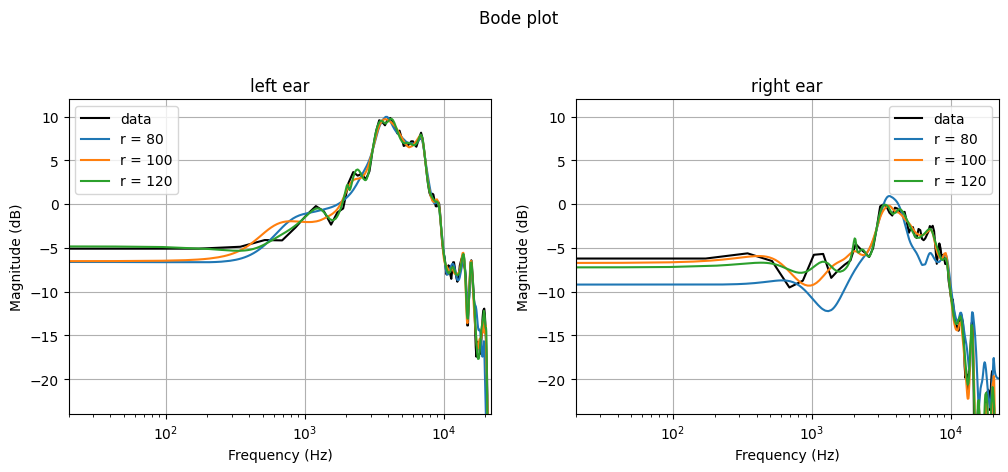

In [39]:
flim = np.array((20, fs/2))
wlim = 2 * np.pi * flim / fs

fig, ax = plt.subplots(2, 2, figsize=(12, 9))
ax = ax.T.ravel()
ax[0].semilogx(np.fft.rfftfreq(256, 1/fs), 20*np.log10(np.abs(np.fft.rfft(ir[:, 0, input_idx]))), color='k', label='data')
ax[2].semilogx(np.fft.rfftfreq(256, 1/fs), 20*np.log10(np.abs(np.fft.rfft(ir[:, 1, input_idx]))), color='k', label='data')
for order, rom in sliced_roms.items():
    rom.transfer_function.bode_plot(wlim, ax=ax, dB=True, Hz=True, label=f'r = {order}')
ax[0].set(xlabel='Frequency (Hz)', title='left ear', xlim=flim, ylim=(-24, 12))
ax[0].legend()
ax[0].grid()
fig.delaxes(ax[1])
ax[2].set(xlabel='Frequency (Hz)', title='right ear', xlim=flim, ylim=(-24, 12))
ax[2].legend()
ax[2].grid()
fig.delaxes(ax[3])

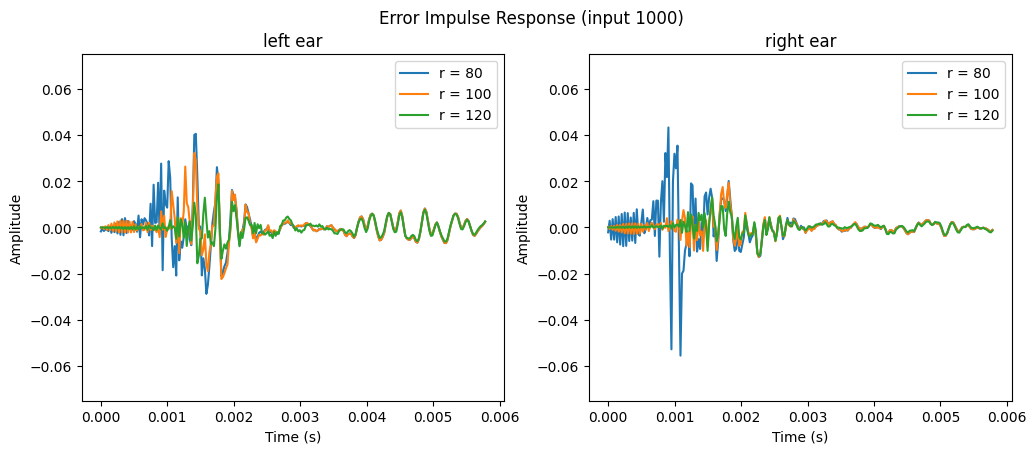

In [14]:
from pymor.algorithms.timestepping import DiscreteTimeStepper

fig, axes = plt.subplots(1, 2)
fig.suptitle(f'Error Impulse Response (input {input_idx})')
for rom in sliced_roms.values():
    rom = rom.with_(T=256, time_stepper=DiscreteTimeStepper())
    hrir = rom.impulse_resp()[1:, :, 0] / fs
    error = ir[..., input_idx] - hrir
    for i, ax in enumerate(axes): 
        ax.plot(t, error[:, i])
        ax.set(xlabel=r'Time (s)', ylabel='Amplitude', title=f'{"left" if i == 0 else "right"} ear', ylim=(-0.075, 0.075))
        ax.legend(('r = 80', 'r = 100', 'r = 120'))